In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../../")
from DanceProj1.DanceObj import Dance
from DanceProj1.data_proc import get_data, data_to_features
import matplotlib.pyplot as plt

In [2]:
from scipy import signal
from scipy.signal import find_peaks, peak_widths

In [3]:
aistpath = '../../aist_keypoints'      #path to 3d keypoints data
dataBM, dataFM = get_data(aistpath)    #get data

#indexes = 0nose, 1L-ear, 2R-ear, 3L-shoulder, 4R-shoulder, 5L-elbow, 6R-elbow, 7L-wrist, 
# 8R-wrist, 9L-hip, 10R-hip, 11L-knee, 12R-knee, 13L-ankle, 14R-ankle

In [4]:
breakdataid = pd.DataFrame(dataFM['Break'], columns=['pose', 'id'])
breakdata = breakdataid['pose']

housedataid = pd.DataFrame(dataFM['House'], columns=['pose', 'id'])
housedata = housedataid['pose']

popdataid = pd.DataFrame(dataFM['Pop'], columns=['pose', 'id'])
popdata = popdataid['pose']

krumpdataid = pd.DataFrame(dataFM['Krump'], columns=['pose', 'id'])
krumpdata = krumpdataid['pose']


print(breakdata[0].shape, housedata[0].shape, popdata[0].shape, krumpdata[0].shape)

(15, 2302, 3) (15, 1919, 3) (15, 1771, 3) (15, 1919, 3)


In [5]:
breakdataid.head()

,pose,id
0,"[[[-37.2453321280263, 164.81916088945948, -7.4...",gBR_sFM_cAll_d05_mBR2_ch09
1,"[[[-28.104818974028607, 170.73762056099753, 19...",gBR_sFM_cAll_d04_mBR5_ch06
2,"[[[-9.474825950224703, 196.02542995262422, 0.2...",gBR_sFM_cAll_d06_mBR2_ch16
3,"[[[-7.053650571821774, 211.45426304109083, 17....",gBR_sFM_cAll_d04_mBR3_ch04
4,"[[[-34.06971385193801, 143.944929665691, -15.7...",gBR_sFM_cAll_d04_mBR2_ch03


In [6]:
#do the above cell but in a loop all at once
idx = 8
breakhousepopkrump = []

for dance in (breakdata[idx], housedata[idx], popdata[idx], krumpdata[idx]):
    dance1 = Dance(dance, 1/60)
    dance1.get_movedata()
    danceaccel = dance1.movedata[2]
    dance1.get_sacrum()
    breakhousepopkrump.append(dance1)
    
break1 = breakhousepopkrump[0]
house1 = breakhousepopkrump[1]
pop1 = breakhousepopkrump[2]
krump1 = breakhousepopkrump[3]
print(break1.pos.shape, house1.pos.shape, pop1.pos.shape, krump1.pos.shape)

(15, 1919, 3) (15, 1706, 3) (15, 2093, 3) (15, 2093, 3)


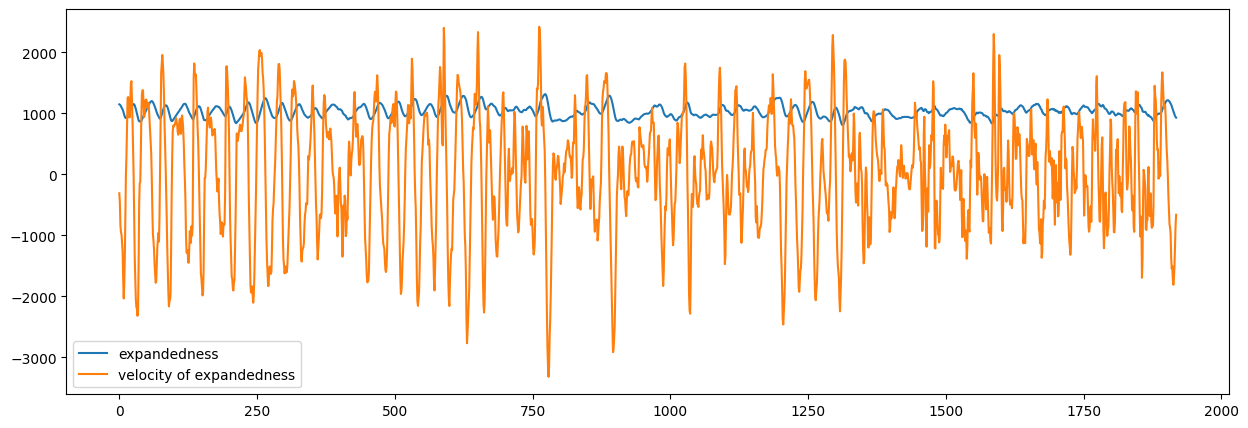

In [29]:
#calculate expandedness of break1
break1.get_sacrum()
Dsfromsacrum = np.empty_like(break1.pos)  #inits for diff in pos, vel, and accel from sacrum
                
for j in range(break1.numjoints):                         #DISTANCE of each joint from sacrum                                    
        Dsfromsacrum[j] = np.abs((break1.pos[j] - break1.sacrum[0]))
        
expa = Dsfromsacrum.sum(axis=0)                         #sum over joints to get expandedness per frame per dimension
expa = expa.sum(axis=1)                                 #sum over dimensions to get expandedness over frames

#calculate velocity and acceleration of expandedness
expavel = np.gradient(expa, krump1.dt)                   #velocity of expandedness
expaaccel = np.gradient(expavel, krump1.dt)              #acceleration of expandedness


#plot expandedness and velocity of expandedness
plt.figure(figsize=(15,5))
plt.plot(expa, label='expandedness')
plt.plot(expavel, label='velocity of expandedness')
plt.legend()
plt.show()



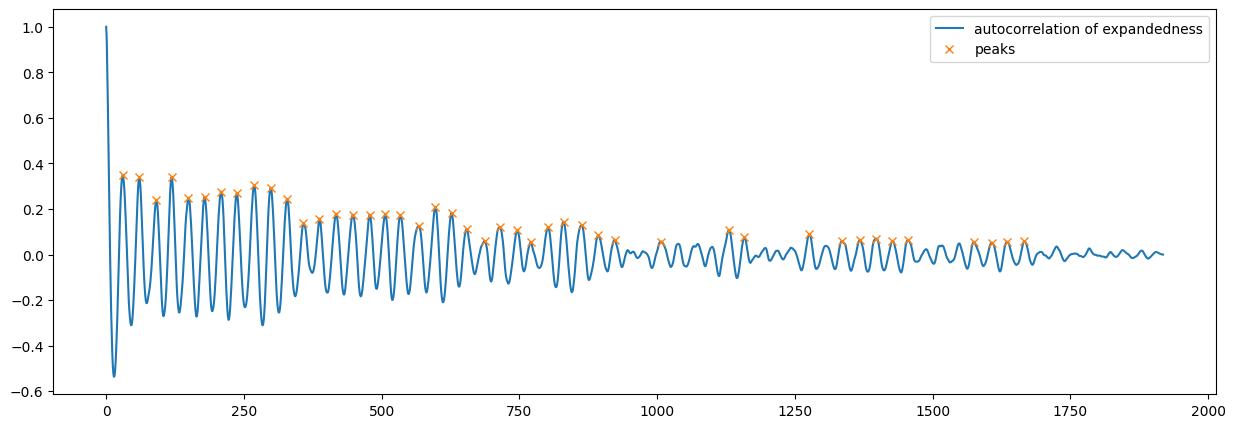

In [30]:
#calculate autocorrelation of expandedness velocity
expaautocorr = np.correlate(expavel, expavel, mode='full')     #autocorrelation of expandedness
expaautocorr = expaautocorr[expaautocorr.size//2:]       #take only the second half of the autocorrelation
expaautocorr = expaautocorr/expaautocorr[0]              #normalize autocorrelation
#find peaks and prominences of autocorrelation
expaautocorrpeaks, expaautocorrproperties = find_peaks(expaautocorr, height=0.05, distance=10, prominence=0.05)
expaautocorrprominences = expaautocorrproperties['prominences']
#find widths of autocorrelation peaks
expaautocorrwidths = peak_widths(expaautocorr, expaautocorrpeaks, rel_height=0.5)
expaautocorrwidths = expaautocorrwidths[0]
expaautocorrwidths = expaautocorrwidths*krump1.dt        #convert widths from frames to seconds
#plot autocorrelation of expandedness with peaks
plt.figure(figsize=(15,5))
plt.plot(expaautocorr, label='autocorrelation of expandedness')
plt.plot(expaautocorrpeaks, expaautocorr[expaautocorrpeaks], "x", label='peaks')
plt.legend()
plt.show()



In [8]:
#get expandedness of each dance
break1.get_expandedness()
house1.get_expandedness()
pop1.get_expandedness()
krump1.get_expandedness()


In [12]:
break1.features

{'sacrumstd': 33.34563013355185,
 'sacrumjerkmag': 1292.669225534609,
 'sacrumjerky': 4.306154154701018,
 'Expandedness': 1031.8726095106094,
 'Expandedness_std': 93.22832920796907}

In [7]:
# #calculate angular momentum for the break, house, pop, krump dances
# angmombr = np.empty_like(break1.pos[0])
# angmomho = np.empty_like(house1.pos[0])
# angmompo = np.empty_like(pop1.pos[0])
# angmomkr = np.empty_like(krump1.pos[0])

# for frame in range(len(break1.pos[0])):
#     for j in range(len(break1.pos)):
#         angmombr[frame] = np.cross(break1.pos[j][frame] - break1.sacrum[0][frame], break1.velocity[j][frame])
#         angmomho[frame] = np.cross(house1.pos[j][frame] - house1.sacrum[0][frame], house1.velocity[j][frame])
#         angmompo[frame] = np.cross(pop1.pos[j][frame] - pop1.sacrum[0][frame], pop1.velocity[j][frame])
#         angmomkr[frame] = np.cross(krump1.pos[j][frame] - krump1.sacrum[0][frame], krump1.velocity[j][frame])

        


In [8]:
angmombr = np.empty_like(break1.pos[0])

for f in range(break1.numframes):
        for j in range(len(break1.pos)):
            angmombr[f] = np.cross(break1.pos[j][f] - break1.sacrum[0][f], break1.velocity[j][f])
angmombrmean = angmombr.mean()

angmomho = np.empty_like(house1.pos[0])

for f in range(house1.numframes):
        for j in range(len(house1.pos)):
            angmomho[f] = np.cross(house1.pos[j][f] - house1.sacrum[0][f], house1.velocity[j][f])
angmomhomean = angmomho.mean()

angmompo = np.empty_like(pop1.pos[0])

for f in range(pop1.numframes):
        for j in range(len(pop1.pos)):
            angmompo[f] = np.cross(pop1.pos[j][f] - pop1.sacrum[0][f], pop1.velocity[j][f])
angmompomean = angmompo.mean()

angmomkr = np.empty_like(krump1.pos[0])

for f in range(krump1.numframes):
        for j in range(len(krump1.pos)):
            angmomkr[f] = np.cross(krump1.pos[j][f] - krump1.sacrum[0][f], krump1.velocity[j][f])
angmomkrmean = angmomkr.mean()


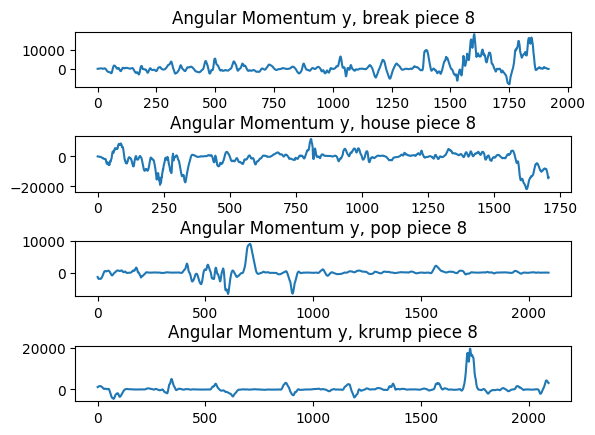

In [9]:
#plot angular momentum, summed across dimensions for a break, house, pop, and krump piece. Four separate figures
fig, ax = plt.subplots(4, 1)
ax[0].plot(angmombr[:,1])
ax[0].set_title('Angular Momentum y, break piece 8')
ax[1].plot(angmomho[:,1])
ax[1].set_title('Angular Momentum y, house piece 8')
ax[2].plot(angmompo[:,1])
ax[2].set_title('Angular Momentum y, pop piece 8')
ax[3].plot(angmomkr[:,1])
ax[3].set_title('Angular Momentum y, krump piece 8')
#create virtual space between subplots
fig.subplots_adjust(hspace=0.9)
plt.show()


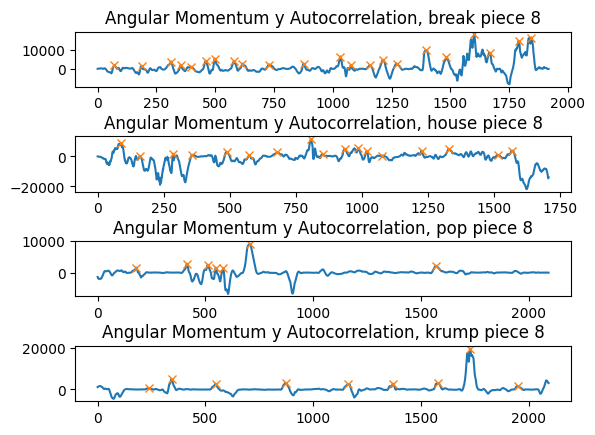

In [18]:
x1 = angmombr[:,1]
x2 = angmomho[:,1]
x3 = angmompo[:,1]
x4 = angmomkr[:,1]

#find the first peak angular momentum y-dimension. Then divide by frame number of that peak.
peaksbr, propertiesbr = find_peaks(x1, prominence=2100, height=0, distance=30, width=10)
peaksbr1 = peaksbr[0]
peaksho, propertiesho = find_peaks(x2, prominence=2100, height=0, distance=30, width=10)
peaksho1 = peaksho[0]
peakspo, propertiespo = find_peaks(x3, prominence=2100, height=0, distance=30, width=10)
peakspo1 = peakspo[0]
peakskr, propertieskr = find_peaks(x4, prominence=2100, height=0, distance=30, width=10)
peakskr1 = peakskr[0]

#plot
fig, ax = plt.subplots(4, 1)
ax[0].plot(x1)
ax[0].plot(peaksbr, x1[peaksbr], "x")
ax[0].set_title('Angular Momentum y Autocorrelation, break piece 8')
ax[1].plot(x2)
ax[1].plot(peaksho, x2[peaksho], "x")
ax[1].set_title('Angular Momentum y Autocorrelation, house piece 8')
ax[2].plot(x3)
ax[2].plot(peakspo, x3[peakspo], "x")
ax[2].set_title('Angular Momentum y Autocorrelation, pop piece 8')
ax[3].plot(x4)
ax[3].plot(peakskr, x4[peakskr], "x")
ax[3].set_title('Angular Momentum y Autocorrelation, krump piece 8')
#create virtual space between subplots
fig.subplots_adjust(hspace=0.9)
plt.show()

In [21]:
len(peaksbr) / len(x1)

0.011464304325169358

In [22]:
len(peaksho) / len(x2)

0.00996483001172333

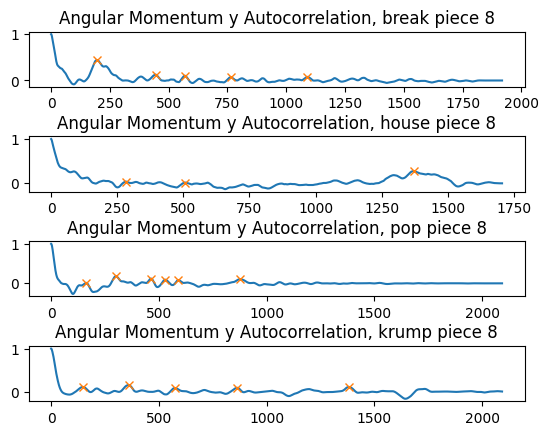

In [23]:
#angular momentum autocorrelation, y-dimension, for a break, house, pop, and krump piece. Four separate figures
x1 = np.correlate(angmombr[:,1], angmombr[:,1], mode='full')
x1 = x1[len(x1)//2:] #take only positive lags
x1 = x1 / x1[0] #normalize

x2 = np.correlate(angmomho[:,1], angmomho[:,1], mode='full')
x2 = x2[len(x2)//2:] #take only positive lags
x2 = x2 / x2[0] #normalize

x3 = np.correlate(angmompo[:,1], angmompo[:,1], mode='full')
x3 = x3[len(x3)//2:] #take only positive lags
x3 = x3 / x3[0] #normalize

x4 = np.correlate(angmomkr[:,1], angmomkr[:,1], mode='full')
x4 = x4[len(x4)//2:] #take only positive lags
x4 = x4 / x4[0] #normalize

#find the first peak angular momentum autocorrelation y-dimension. Then divide by frame number of that peak.
peaksbr, propertiesbr = find_peaks(x1, prominence=.1, height=0, distance=30, width=10)
peaksbr1 = peaksbr[0]
peaksho, propertiesho = find_peaks(x2, prominence=.1, height=0, distance=30, width=10)
peaksho1 = peaksho[0]
peakspo, propertiespo = find_peaks(x3, prominence=.1, height=0, distance=30, width=10)
peakspo1 = peakspo[0]
peakskr, propertieskr = find_peaks(x4, prominence=.1, height=0, distance=30, width=10)
peakskr1 = peakskr[0]

#plot
fig, ax = plt.subplots(4, 1)
ax[0].plot(x1)
ax[0].plot(peaksbr, x1[peaksbr], "x")
ax[0].set_title('Angular Momentum y Autocorrelation, break piece 8')
ax[1].plot(x2)
ax[1].plot(peaksho, x2[peaksho], "x")
ax[1].set_title('Angular Momentum y Autocorrelation, house piece 8')
ax[2].plot(x3)
ax[2].plot(peakspo, x3[peakspo], "x")
ax[2].set_title('Angular Momentum y Autocorrelation, pop piece 8')
ax[3].plot(x4)
ax[3].plot(peakskr, x4[peakskr], "x")
ax[3].set_title('Angular Momentum y Autocorrelation, krump piece 8')
#create virtual space between subplots
fig.subplots_adjust(hspace=0.9)
plt.show()



In [51]:
#find value of first peak in peaksho
peak1ho = x2[peaksho1]
#find value of thehighest peak in peaksho
peakmaxho = x2[peaksho].max()
#find the ratio of the first peak to the highest peak
peakratioho = peak1ho / peakmaxho
#multiply peakratio by the absolute value of number of frames between the first peak and the highest peak, plus one
peaktimeho = peakratioho * (abs(peaksho1 - peaksho.max()) + 1)
#divide by the number of frames in the piece
peaktimeho = peaktimeho / len(x2)

print(peak1ho, peakmaxho, peaktimeho)


0.038968142000029085 0.27518772091685595 0.09039189696837918


In [52]:
#find the prominence of the first peak in peaksho
peakpromho = propertiesho["prominences"][0]
#find the prominence of the highest peak in peaksho
peakprommaxho = propertiesho["prominences"].max()
#find the ratio of the first peak prominence to the highest peak prominence
peakpromratioho = peakpromho / peakprommaxho
#multiply peakpromratio by the absolute value of number of frames between the first peak and the highest peak, plus one
peakpromtimeho = peakpromratioho * (abs(peaksho1 - peaksho.max()) + 1)
#divide by the number of frames in the piece
peakpromtimeho = peakpromtimeho / len(x2)

print(peakpromho, peakprommaxho, peakpromtimeho)

0.13034946101608674 0.3465738114548544 0.24008352012402245


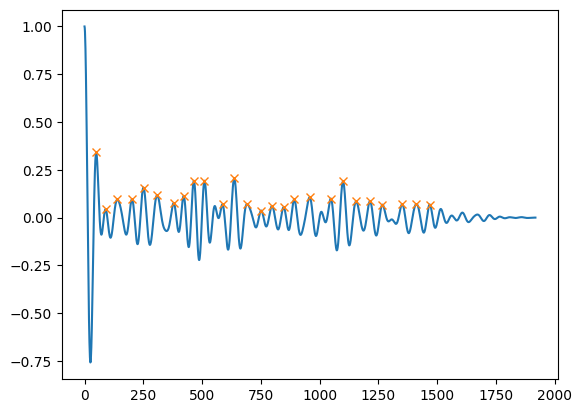

In [11]:


x = np.correlate(bjazzaccel[0].T[1], bjazzaccel[0].T[1], mode='full')
x.shape
x = x[x.size//2:] #take only positive lags
x = x / x[0] #normalize
plt.plot(x)
peaks, properties = find_peaks(x, height=0, distance=30, prominence=0.08)
plt.plot(peaks, x[peaks], "x")
plt.show()

In [20]:
#find the index of the highest 4 peaks
peakstop = peaks[np.argsort(properties['peak_heights'])[-4:][::-1]]
peakstop / len(x)

array([0.02605524, 0.33194372, 0.26576342, 0.24231371])

In [21]:
#get the prominence of the highest 4 peaks
properties['prominences'][np.argsort(properties['peak_heights'])[-4:][::-1]]

array([0.56293167, 0.37713458, 0.36034545, 0.34679345])

In [29]:
#get prominence top three peaks, multiplied by the peak's x position
prominence = properties['prominences']
prominence = prominence * peaks
prominence = np.sort(prominence)
prominence = prominence[::-1]
prominence = prominence[:3]
print(prominence)


[239.29017245 234.99886492 161.84502879]


In [5]:
import numpy as np
gradelist = [94.5,88,91,92.5,87,90.5,98,94,90.5,95.5,87,95.5,91,90,95.5,95.5,84.5,84.5,93,97.5,85.5,90.5,89.5]
#show length, average, and standard deviation of gradelist
print(len(gradelist), np.mean(gradelist), np.std(gradelist))

23 91.34782608695652 3.9382041333380893


/tmp/ipykernel_191/2374676170.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gradelist, shade=True, color='lightblue')


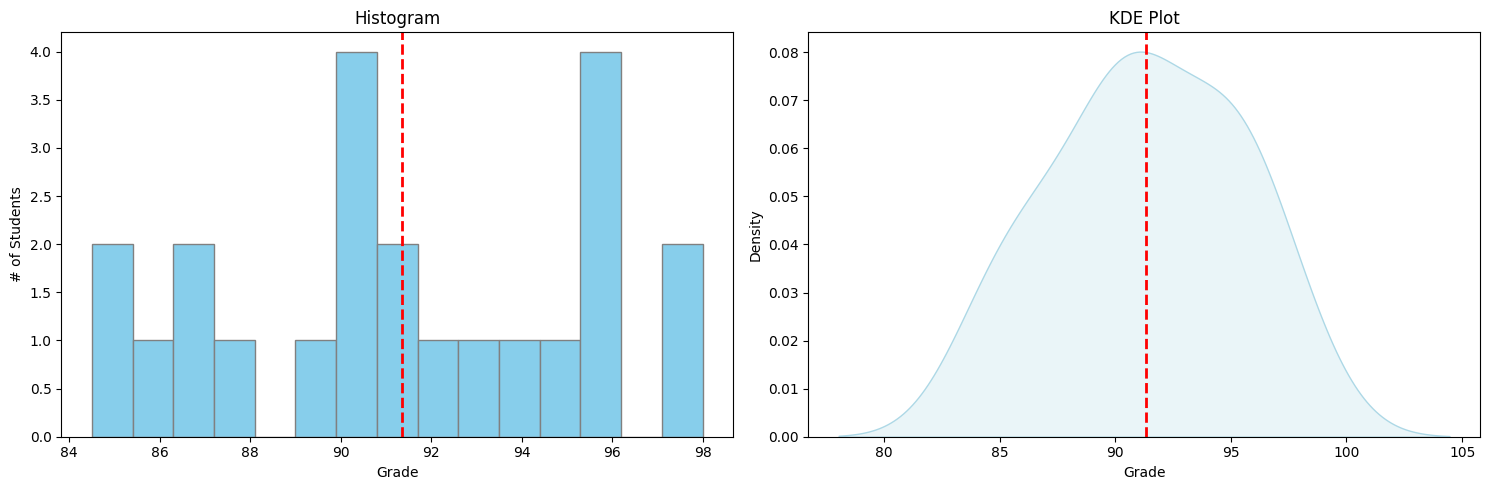

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean of the list
mean_value = np.mean(gradelist)

# Set up the matplotlib figure
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(gradelist, bins=len(set(gradelist)), color='skyblue', edgecolor='gray')
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogram')
plt.xlabel('Grade')
plt.ylabel('# of Students')

# KDE Plot
plt.subplot(1, 2, 2)
sns.kdeplot(gradelist, shade=True, color='lightblue')
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
plt.title('KDE Plot')
plt.xlabel('Grade')

# Display the plots
plt.tight_layout()
plt.show()

